In [7]:
# import zipfile
import gzip
import io
import json
import os
# import requests
from urllib import request

import matplotlib.pyplot as plt
# import mygene
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from graphdriver.load import hgnc, labels, ppi
from graphdriver.utils import config
from graphdriver.utils import constants as cons
from graphdriver.utils import ipynb, paths
from scipy import stats


In [8]:
ipynb.debug()

# Check StringDB data.
Reproduce the graph from EMOGI paper

{ppi.py:39} DEBUG - start string_db
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_string_db


(277339, 3)
  source_symbol target_symbol  confidence
0          A1BG          GAB1         944
1          A1BG        PIK3R1         909
2          A1BG        PTPN11         998
3          A1BG          GRB2         996
4          A1BG          IL6R         900


<Figure size 1008x576 with 0 Axes>

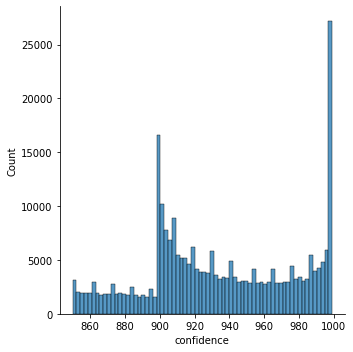

In [17]:
df_string_db = ppi.string_db()
print(df_string_db.shape)
print(df_string_db.head())
fig = plt.figure(figsize=(14, 8))
sns.displot(df_string_db[cons.CONFIDENCE], kde_kws={'bw': 20})

# Check PCNet data.


In [18]:
df_pcnet = ppi.pcnet()
print(df_pcnet.shape)
df_pcnet.head()

{ppi.py:78} DEBUG - start pcnet
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_pcnet


(2579795, 3)


,source_symbol,target_symbol,confidence
0,A1BG,CFHR1,1
1,A1BG,SMN1,1
2,A1BG,SMN2,1
3,A1BG,RTP3,1
4,A1BG,GLS2,1


# Check iRefIndex data.

In [19]:
df_iref = ppi.irefindex()
print(df_iref.shape)
df_iref.head()

{ppi.py:126} DEBUG - start irefindex
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_irefindex


(466254, 3)


,source_symbol,target_symbol,confidence
0,A1BG,SETD7,1
1,A1BG,UBAC1,1
2,A1BG,KCMF1,1
3,A1BG,SNCA,1
4,A1BG,TK1,1


# Check CPDB data.

In [20]:
df_cpdb = ppi.cpdb()
print(df_cpdb.shape)
df_cpdb.head()

{ppi.py:172} DEBUG - start dpdb
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_cpdb


(329098, 3)


,confidence,source_symbol,target_symbol
0,0.958028,A1BG,PRDX4
1,0.546707,A1CF,CELF2
2,0.832988,A1CF,POGZ
3,0.736783,A1CF,FHL3
4,0.751266,A1CF,EIF4G1


### CPDB comparasion with EMOGI
The data is very different as seen in the printout below. Only 2 out 5 protein pairs are overlapping and even those have different confidence levels.  
The node degree shows similaritys, however.

In [13]:
df_similar = df_cpdb[(df_cpdb[cons.SYM_SOURCE] == "STIM1") & (df_cpdb[cons.SYM_TARGET] =="TRPC1")]
df_similar = df_similar.append(df_cpdb[(df_cpdb[cons.SYM_SOURCE] == "NOS1") & (df_cpdb[cons.SYM_TARGET] =="ATP2B4")])
df_similar = df_similar.append(df_cpdb[(df_cpdb[cons.SYM_SOURCE] == "ABCC9") & (df_cpdb[cons.SYM_TARGET] =="KCNJ11")])
df_similar = df_similar.append(df_cpdb[(df_cpdb[cons.SYM_SOURCE] == "HADHA") & (df_cpdb[cons.SYM_TARGET] =="HADHB")])
df_similar = df_similar.append(df_cpdb[(df_cpdb[cons.SYM_SOURCE] == "GTF2E2") & (df_cpdb[cons.SYM_TARGET] =="GTF2E1")])
df_similar

,confidence,source_symbol,target_symbol
278156,0.597177,STIM1,TRPC1
580,0.990732,ABCC9,KCNJ11


Constructed Adjacency Matrix with average node degree of: 46.615777163512654
Adjacency matrix has 328851 edges and 14109 nodes in total


/home/joe/miniconda3/envs/graph1/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Node Degree Distribution of Genes in PPI')

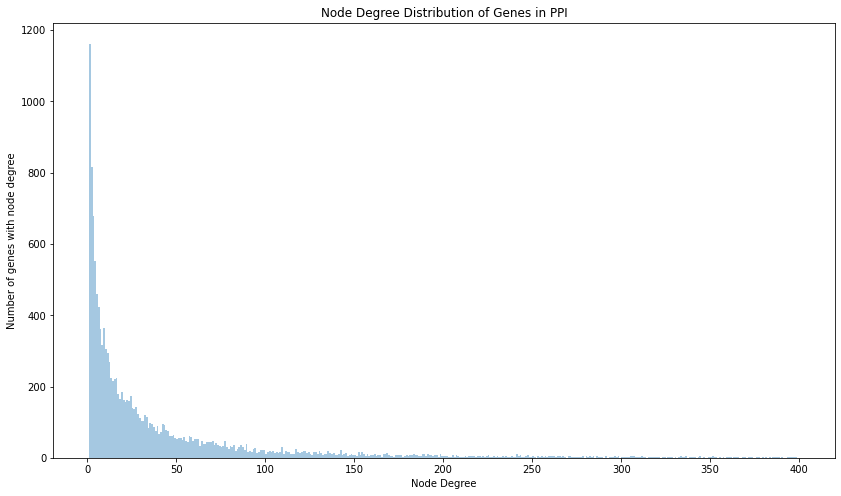

In [14]:
G = nx.from_pandas_edgelist(df=df_cpdb, source=cons.SYM_SOURCE, target=cons.SYM_TARGET, edge_attr=cons.CONFIDENCE)
adj_pd = nx.to_pandas_adjacency(G)
adjacency_matrix = adj_pd.values
node_names = adj_pd.index.values

avg_node_degree = np.mean([value for key, value in G.degree()])
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges and {} nodes in total".format(G.number_of_edges(), G.number_of_nodes()))
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 400, 400)
sns.distplot(node_degrees, kde=False, bins=bins)

#ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

# Check that all networks are directed without duplicates

In [15]:
ppis = ppi.PPIs()
for k in ppis.ppis:
    dd = ppis.ppis[ppis.PCNET]
    dm = dd.append(dd.rename(columns={cons.SYM_SOURCE: cons.SYM_TARGET, cons.SYM_TARGET: cons.SYM_SOURCE}))
    dm = dm.drop_duplicates(subset=[cons.SYM_SOURCE, cons.SYM_TARGET])
    if dd.shape != dm.shape:
        if dd.shape[0] * 2 == dm.shape[0]:
            print(k + " is directed without duplicates")
        else:
            print(k + " is directed with duplicates")
    else:
        print(k + " is undirected")

{ppi.py:39} DEBUG - start string_db
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_string_db
{ppi.py:78} DEBUG - start pcnet
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_pcnet
{ppi.py:126} DEBUG - start irefindex
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_irefindex
{ppi.py:172} DEBUG - start dpdb
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_cpdb


string_db is directed without duplicates
pcnet is directed without duplicates
irefindex is directed without duplicates
cpdb is directed without duplicates


# How often do connections appear inbetween different PPIs?
What we can see is that there is a big difference between the PPIs.
Most connections (directional) occur only in one database (~87%).
Only ~0.003% of connections occur in all PPIs.  
We cannot compare the confidence of the connections as two networks don't include them.

In [16]:
from graphdriver.load import labels, ppi
from graphdriver.utils import paths, constants as cons

path = paths.tmp_path("pancancer", "ppis_series.pickle")
if os.path.isfile(path):
    series = paths.pickle_load(path)
else:
    ppis = ppi.PPIs()
    series = {}
    for k in ppis.ppis:
        series[k] = ppis.ppis[k][[cons.SYM_SOURCE,cons.SYM_TARGET]].agg(','.join, axis=1).values.astype(str)
    paths.pickle_save(path, series)

{ppi.py:39} DEBUG - start string_db
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_string_db
{ppi.py:78} DEBUG - start pcnet
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_pcnet
{ppi.py:126} DEBUG - start irefindex
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_irefindex
{ppi.py:172} DEBUG - start dpdb
{paths.py:136} DEBUG - load dataframe from: /home/joe/repos/graphDriver/data/tmp/pancancer_cpdb
{paths.py:141} DEBUG - save pickle to: /home/joe/repos/graphDriver/data/tmp/pancancer_ppis_series.pickle


In [ ]:
values = None
for k in series:
    v = series[k].astype(str)
    # quick check if values are ok
    where = [np.where(values == "nan"), np.where(values == ""),np.where(values == " ")]
    for w in where:
        if w[0].size > 0:
            raise ValueError("Values are not correct for " + k) 
    if values is None:
        values = v
    else:
        values = np.append(values, v, axis=0)

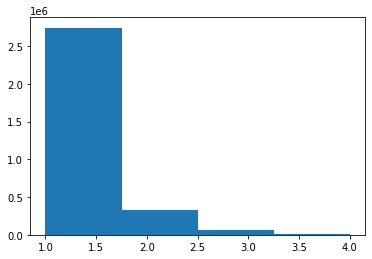

[0.86961821 0.10561258 0.02216651 0.0026027 ]


In [ ]:
unique, counts = np.unique(values, return_counts=True)
(n, bins, patches) = plt.hist(counts, bins=4, label='hst')
plt.show()
print(n/np.sum(n))

The array above shows the percentage  
Below is the same graph as pie chart

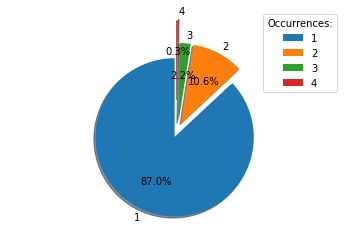

In [ ]:
bins = np.bincount(counts)[1:]
bins_rel = bins/np.sum(bins)
labls = '1', '2', '3', '4'
fig1, ax1 = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.4)
ax1.pie(bins_rel, explode=explode, labels=labls, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.legend(title = "Occurrences:")
plt.show()

### No compare each dataset seperately 

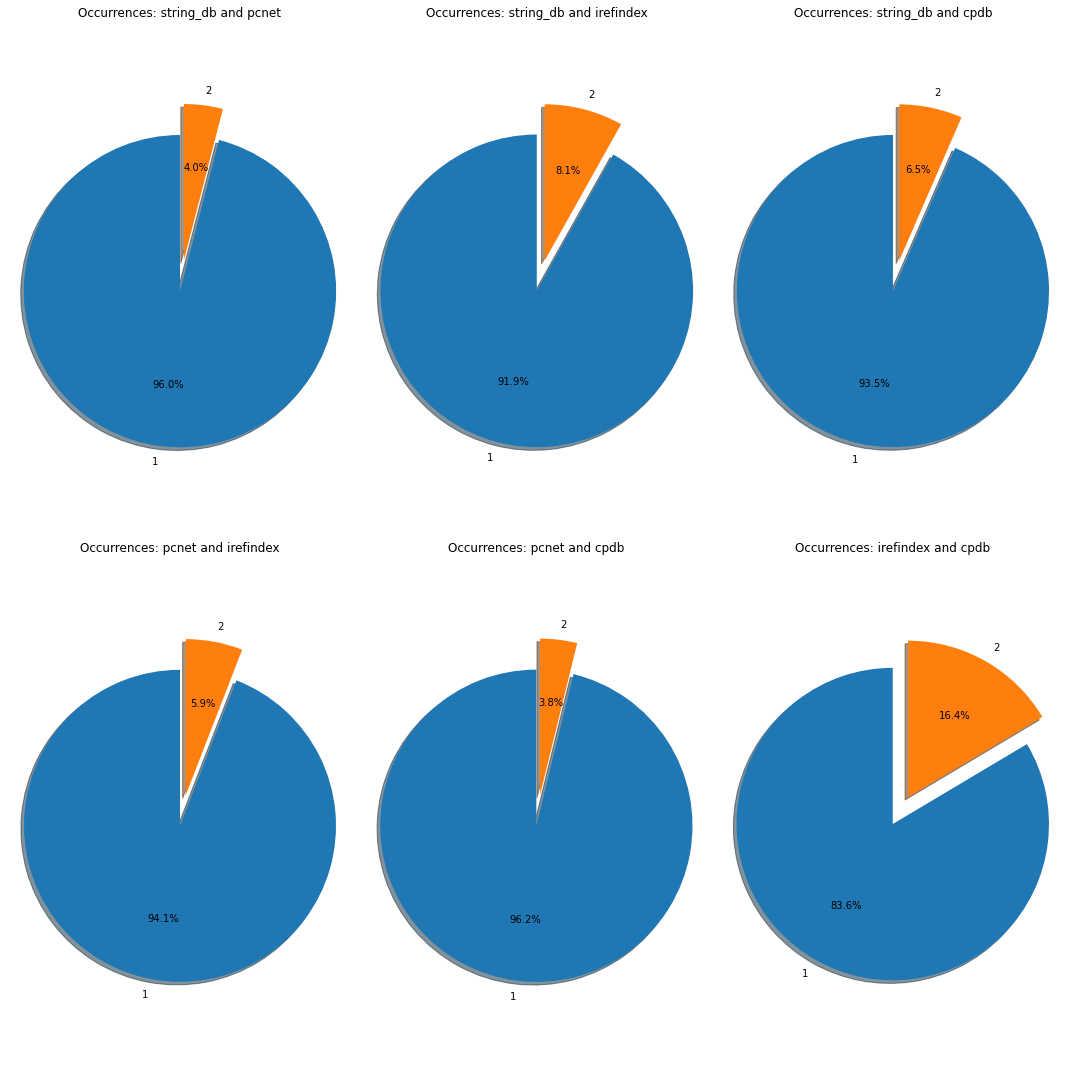

In [ ]:
import itertools

def bins(values):
    unique, counts = np.unique(values, return_counts=True)
    return np.bincount(counts)[1:]
    

values = []
for c in list(itertools.combinations(range(len(series)), 2)):
    v = np.append(list(series.values())[c[0]],list(series.values())[c[1]])
    values.append((bins(v), list(series.keys())[c[0]], list(series.keys())[c[1]]))

f,a = plt.subplots(2,3)
a = a.ravel()
f.set_figheight(15)
f.set_figwidth(15)
for idx,ax in enumerate(a):
    v = values[idx]
    labls = '1', '2'
    explode = (0.1, 0.1)
    ax.pie(v[0], explode=explode, labels=labls, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.axis('equal')
    ax.set_title("Occurrences: " + v[1] + " and " + v[2])
plt.tight_layout()



## How do occurence compare across different networks?
We can see that most proteins occur around <40 times.  
PCNet is different than the 3 others at >150 times.

In [ ]:
ppis = ppi.PPIs()
values = []
for k in ppis.ppis:
     v = ppis.ppis[k][[cons.SYM_SOURCE, cons.SYM_TARGET]].values.flatten()
     unique, counts = np.unique(v, return_counts=True)
     values.append([k,counts])
     

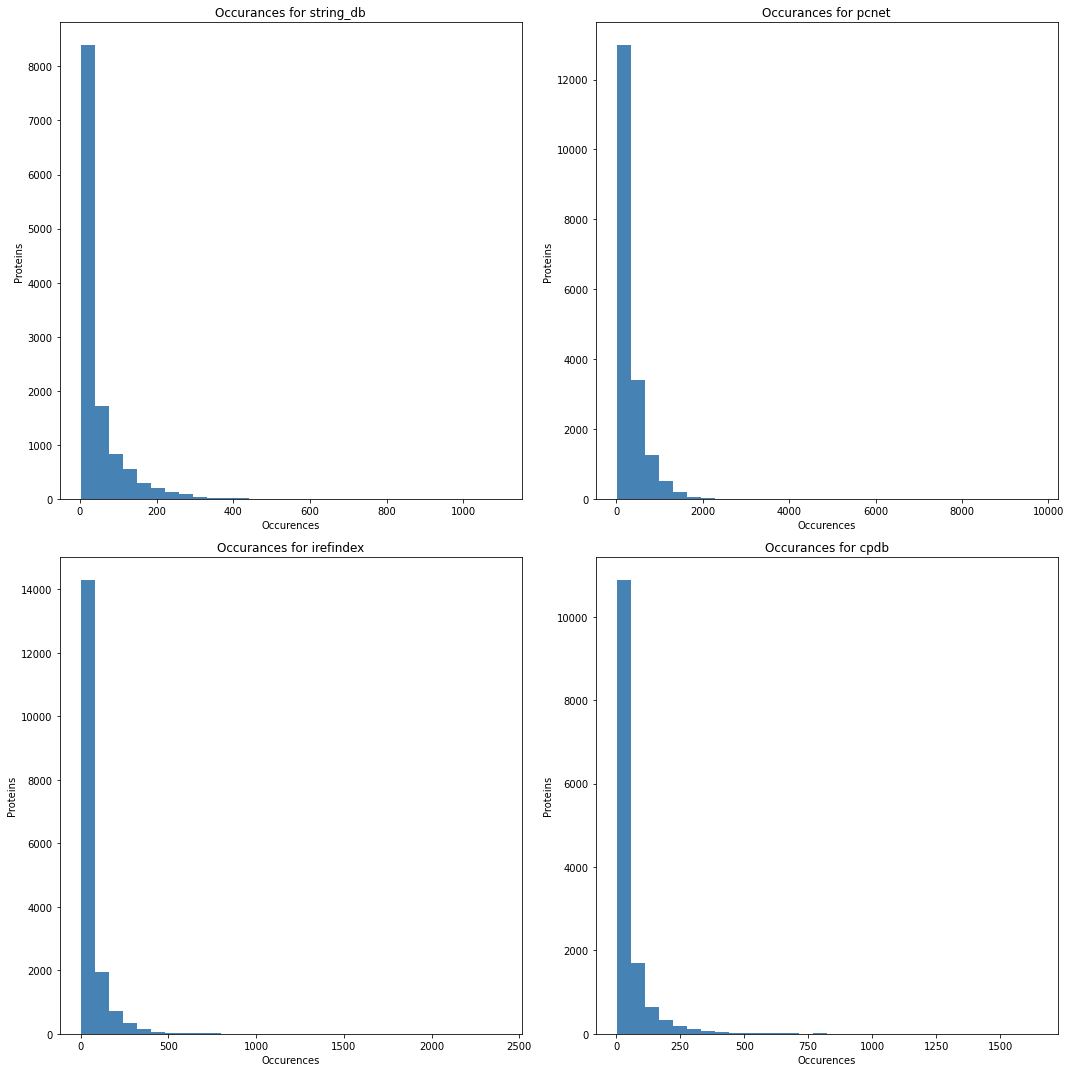

In [ ]:
f,a = plt.subplots(2,2)
a = a.ravel()
f.set_figheight(15)
f.set_figwidth(15)
for idx,ax in enumerate(a):
    ax.hist(values[idx][1], bins=30, color='steelblue')
    ax.set_title("Occurances for " + values[idx][0])
    ax.set_xlabel("Occurences")
    ax.set_ylabel("Proteins")
plt.tight_layout()

In [ ]:
for v in values:
    print(v[0] + ": " + str(stats.describe(v[1])))

string_db: DescribeResult(nobs=12388, minmax=(2, 1098), mean=44.77542783338715, variance=4626.183841142527, skewness=3.808844462034388, kurtosis=26.416956850403857)
pcnet: DescribeResult(nobs=18495, minmax=(1, 9731), mean=278.9721546363882, variance=110638.72124254557, skewness=3.3705019115103, kurtosis=42.06657527637905)
irefindex: DescribeResult(nobs=17624, minmax=(1, 2395), mean=52.91125737630504, variance=8172.364024657353, skewness=5.867649993028033, kurtosis=70.52877024299275)
cpdb: DescribeResult(nobs=14109, minmax=(1, 1643), mean=46.65079027571054, variance=7988.755772872727, skewness=6.011397097397198, kurtosis=59.665986490037454)


# Compare PPI genes to drivers
How is the relative occurance of drivers compared candidates.  
I will also compare them to the "passengers" (ie all others), but the passengers are not the once used later.
The hgnc list is too broad and the ppi list is too narrow.

In [ ]:
conf = config.Conf("pancancer")
df_drivers, df_candidates = labels.load_positives(conf)
df_drivers = hgnc.keep_hgnc(df_drivers)
df_candidates = hgnc.keep_hgnc(df_candidates)

ppis = ppi.PPIs()
ratios = {}
for k in ppis.ppis:
    df = ppis.ppis[k]
    total = df.shape[0]*2
    in_drivers = df[(df[cons.SYM_SOURCE].isin(df_drivers[cons.SYMBOL])) | (df[cons.SYM_TARGET].isin(df_drivers[cons.SYMBOL]))].shape[0]
    in_candidates =df[df[cons.SYM_SOURCE].isin(df_candidates[cons.SYMBOL]) | (df[cons.SYM_TARGET].isin(df_candidates[cons.SYMBOL]))].shape[0]
    out = total - in_drivers - in_candidates
    ratios[k] = [total,in_drivers,in_candidates, out]
print("labels".ljust(15) + "\t" + "[drivers   candidates  passengers]")
for k in ratios:
    print(k.ljust(15) + "\t" + str(np.array(ratios[k][1:])/ratios[k][0]))

averages  = np.average(np.array(list(ratios.values()))[:,1:]/np.array(list(ratios.values()))[:,0:1],axis=0)
np.testing.assert_approx_equal(np.sum(averages),1)
print("average".ljust(15) + "\t" + str(averages))

labels         	[drivers   candidates  passengers]
string_db      	[0.09216879 0.40631682 0.50151439]
pcnet          	[0.06907874 0.40800684 0.52291442]
irefindex      	[0.08157249 0.41063669 0.50779082]
cpdb           	[0.1078387  0.42583668 0.46632462]
average        	[0.08766468 0.41269926 0.49963606]


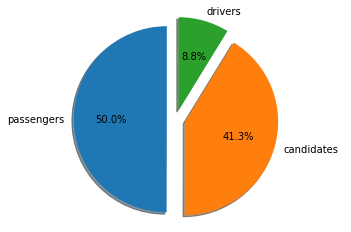

In [ ]:
# and as plot
fig1, ax1 = plt.subplots()
explode = (0.1, 0.1, 0.1)
labls = ["drivers", "candidates", "passengers"]
labls.reverse()
ax1.pie(averages[::-1], explode=explode, labels=labls, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()